In [10]:
# Import Packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

# Output dataframes instead of arrays
set_config(transform_output="pandas")

In [11]:
!pip install openpyxl

In [12]:
ttc = pd.read_excel('ttc-streetcar-delay-data-2024_cleaned.xlsx')
ttc.head()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season
0,2024-04-28,301,03:54,Sunday,WOLSELEY LOOP,Cleaning - Unsanitary,30,60,E,8118,4,18,28,3,Spring
1,2024-09-14,301,02:23,Saturday,WOLSELEY LOOP,Utilized Off Route,30,60,W,8112,9,37,14,2,Summer
2,2024-01-28,301,02:11,Sunday,WARDEN AND COMSTOCK,Mechanical,10,20,W,8734,1,5,28,2,Winter
3,2024-11-15,301,02:35,Friday,THE QUEENSWAY AND WIND,Security,24,39,W,4588,11,46,15,2,Fall
4,2024-08-25,301,03:11,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10,30,E,4569,8,35,25,3,Summer


In [13]:
# Drop Location
# Dropping "Date" and "Time", as we will being "Month", "Week", "Day of Month", and "Hour of Day"

post_cleaning = ttc.drop(columns=['Date', 'Time', 'Location']).dropna()
post_cleaning.head()

,Line,Day,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season
0,301,Sunday,Cleaning - Unsanitary,30,60,E,8118,4,18,28,3,Spring
1,301,Saturday,Utilized Off Route,30,60,W,8112,9,37,14,2,Summer
2,301,Sunday,Mechanical,10,20,W,8734,1,5,28,2,Winter
3,301,Friday,Security,24,39,W,4588,11,46,15,2,Fall
4,301,Sunday,Mechanical,10,30,E,4569,8,35,25,3,Summer


In [14]:
# Create the binary target

post_cleaning['delay_flag'] = (post_cleaning['Min Delay'] > 20).astype(int)

# Encode the categorical variables using One Hot Encoder.

encoded_df = pd.get_dummies(post_cleaning, columns=['Day', 'Incident', 'Bound', 'Season'], drop_first=False)

encoded_df.head()

,Line,Min Delay,Min Gap,Vehicle,Month,Week,Day of Month,Hour of Day,delay_flag,Day_Friday,...,Bound_8,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,301,30,60,8118,4,18,28,3,1,False,...,False,False,True,False,False,False,False,True,False,False
1,301,30,60,8112,9,37,14,2,1,False,...,False,False,False,False,False,True,False,False,True,False
2,301,10,20,8734,1,5,28,2,0,False,...,False,False,False,False,False,True,False,False,False,True
3,301,24,39,4588,11,46,15,2,1,True,...,False,False,False,False,False,True,True,False,False,False
4,301,10,30,4569,8,35,25,3,0,False,...,False,False,True,False,False,False,False,False,True,False


In [15]:
# Split the data

from sklearn.model_selection import train_test_split

X = encoded_df.drop(columns=['Min Delay', 'delay_flag', 'Min Gap'])
y = encoded_df['delay_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#Scale features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
X_test_scaled = scaler.transform(X_test)        # Transform test data using same scaler

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [18]:
# Make Predictions 
y_pred = log_reg.predict(X_test_scaled)

# Evaluate performance 

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8394648829431438

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2003
           1       0.51      0.35      0.41       389

    accuracy                           0.84      2392
   macro avg       0.70      0.64      0.66      2392
weighted avg       0.82      0.84      0.83      2392


Confusion Matrix:
 [[1873  130]
 [ 254  135]]


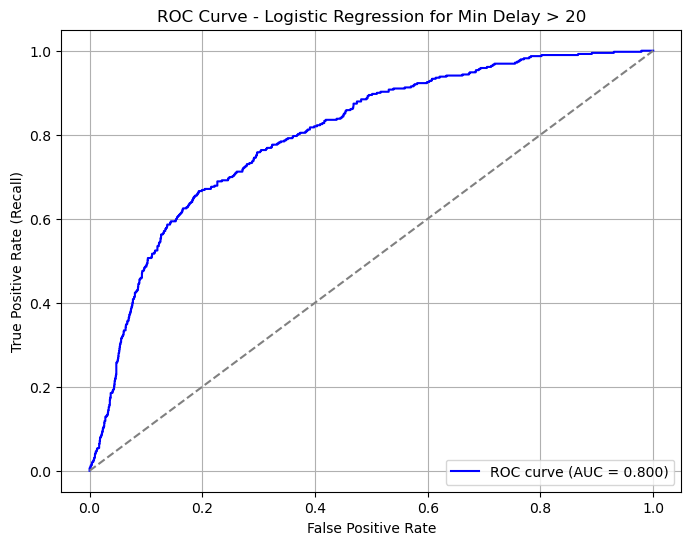

In [19]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (delay_flag=1)
y_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Logistic Regression for Min Delay > 20')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()